In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
ds = xr.open_dataset('../raster_outputs/r025/firespain_025_WGS84_v0.3.nc')

# Convertir el conjunto de datos a un DataFrame de Pandas
# Primero, si quieres trabajar con un DataFrame con las variables como columnas:
df = ds.to_dataframe()

In [3]:
df = df.reset_index()

In [4]:
#Metemos un indice para pares coordenadas latitude longitud específicas
lat_lon = df[['longitude','latitude']].drop_duplicates()
lat_lon = lat_lon.reset_index(drop = True).reset_index().rename(columns = {'index' : 'pixel'})
df = pd.merge(lat_lon,df,how = 'inner', on = ['longitude','latitude'])
#Eliminamos NA ya que pueden ser agua
df = df.dropna()

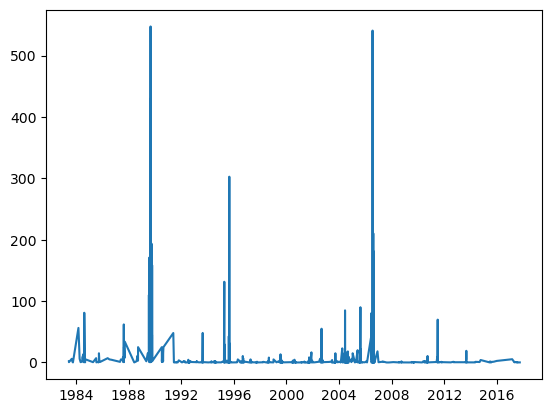

In [6]:
pixel = 35
df_pixel = df[df['pixel'] == pixel]
df_pixel = df_pixel[['time','ba']].set_index('time')
plt.plot(df_pixel)
plt.show()

Se puede ver una regularidad estacional

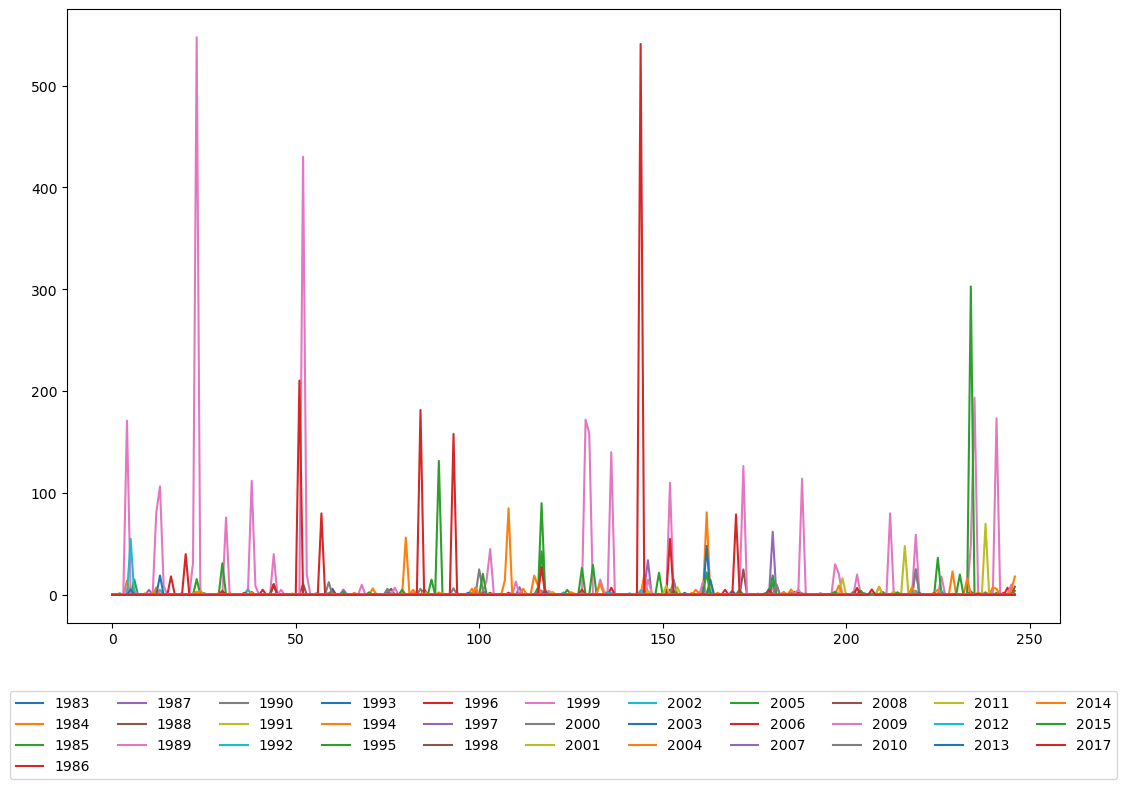

In [120]:
pixel = 35

df_pixel = df[df['pixel'] == pixel]
df_pixel = df_pixel[['time','ba']].set_index('time')
df_pixel = df_pixel.reset_index()
df_pixel['dia_mes'] = df_pixel['time'].dt.strftime('%d-%m') 
df_pixel['año'] = df_pixel['time'].dt.year
df_pixel = df_pixel.pivot_table(index='dia_mes', columns='año', values='ba', aggfunc='first')
df_pixel = df_pixel.reset_index(drop = True)
df_pixel = df_pixel.fillna(0)
plt.figure(figsize=(12, 8)) 
for year in df_pixel.columns:
    serie = df_pixel[year]
    plt.plot(serie,label = year)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=11) 
plt.tight_layout()
plt.show()

### Promedios

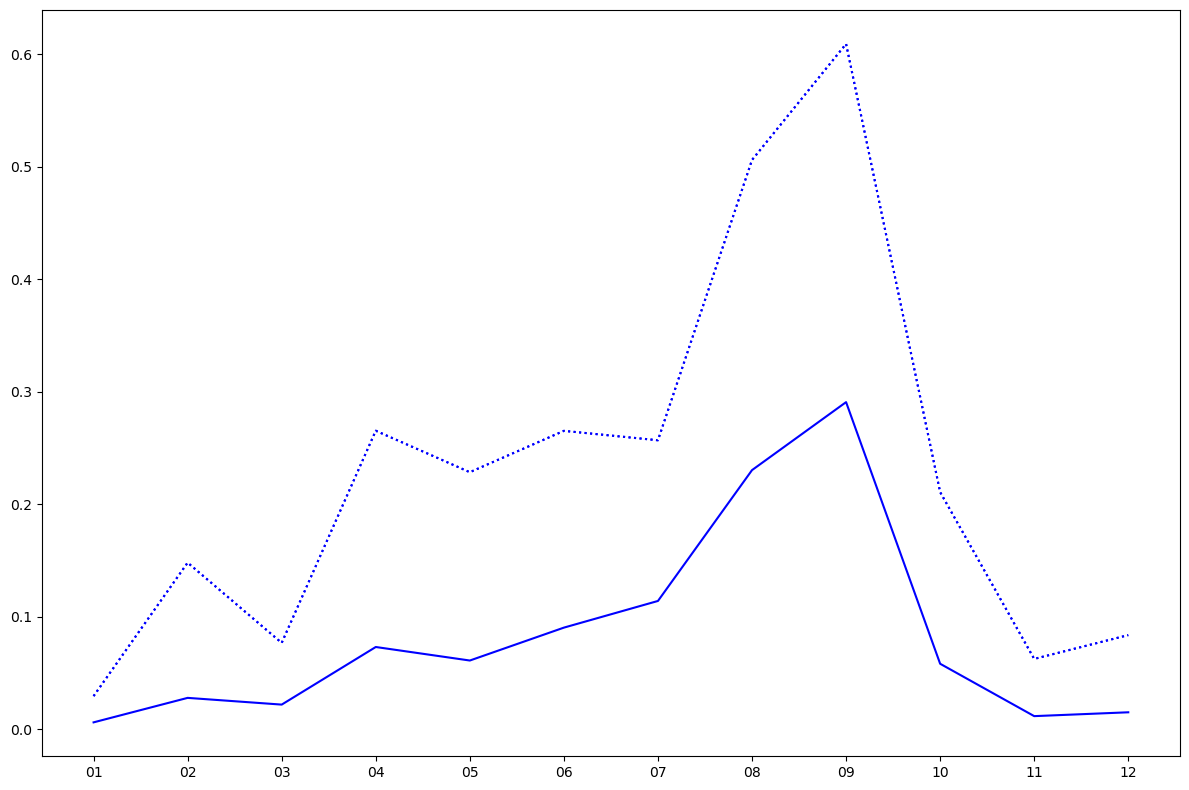

In [179]:
pixel = 35 
df_pixel = df[df['pixel'] == pixel]
df_pixel = df_pixel[['time','ba']].set_index('time')
df_pixel = df_pixel.reset_index()
df_pixel['mes'] = df_pixel['time'].dt.strftime('%m') 
df_pixel['año'] = df_pixel['time'].dt.year
df_pixel = df_pixel.pivot_table(index='mes', columns='año', values='ba', aggfunc='sum')
df_pixel = df_pixel.fillna(0)
df_pixel = df_pixel.div(df_pixel.sum(), axis=1)

serie = df_pixel.T.mean()
serie_std = df_pixel.T.std()
serie_max = df_pixel.T.max()
plt.figure(figsize=(12, 8)) 
plt.plot(serie, color='Blue')
plt.plot(serie + serie_std, linestyle='dotted', color='Blue')
plt.plot(serie + serie_std, linestyle='dotted', color='Blue')
plt.tight_layout()
plt.show()

### Conteo

#### Proporción total de área quemada

Sumar la cantidad de tierra quemada total por mes y normalizar para saber qué meses tienen más área quemada. Hecho esto, establecer un threshold mínimo para considerar si un mes entra o no en la estación de incendios. Por ejemplo: 0.1

In [195]:
df_pixel = df[df['pixel'] == pixel]
df_pixel = df_pixel[['time','ba']].set_index('time')
df_pixel = df_pixel.reset_index()
df_pixel['mes'] = df_pixel['time'].dt.strftime('%m') 
df_pixel['año'] = df_pixel['time'].dt.year
df_pixel = df_pixel.pivot_table(index='mes', columns='año', values='ba', aggfunc='sum')
df_pixel = df_pixel.fillna(0)
df_pixel = df_pixel.div(df_pixel.sum(), axis=1)
fireSeason = df_pixel.T.mean()
#print(fireSeason)
fireSeason_cumsum = fireSeason.sort_values(ascending = False).cumsum()
print(df_cumsum)
indices = fireSeason_cumsum[fireSeason_cumsum <= 0.9].index
print('La fire season será: ', sorted(indices))

mes
09    0.290661
08    0.520907
07    0.634888
06    0.725167
04    0.798233
05    0.859282
10    0.917466
02    0.945328
03    0.967209
12    0.982255
11    0.993894
01    1.000000
dtype: float32
La fire season será:  ['04', '05', '06', '07', '08', '09']


#### Frecuencia incendios

In [219]:
df_pixel = df[df['pixel'] == pixel]
df_pixel = df_pixel[['time','ba']].set_index('time')
df_pixel['ba'] = (df_pixel['ba'] > 0).astype(int)
df_pixel = df_pixel.reset_index()
df_pixel['mes'] = df_pixel['time'].dt.strftime('%m') 
df_pixel['año'] = df_pixel['time'].dt.year
df_pixel = df_pixel.pivot_table(index='mes', columns='año', values='ba', aggfunc='sum')
df_pixel = df_pixel.fillna(0)
fire_season = df_pixel.T.sum()/817 #hay 817 días donde ha ocurrido incencios
print(fire_season.sort_values(ascending = False))
indices = fire_season[fire_season >= 0.1].index #incluimos que al menos el 10% de las veces haya ocurrido en el mes especifico para incluirlo en la estación de incendios
indices

mes
08    0.259486
09    0.209302
07    0.166463
06    0.100367
10    0.062424
04    0.050184
05    0.042840
03    0.029376
02    0.023256
12    0.013464
01    0.011016
11    0.011016
dtype: float64


Index(['06', '07', '08', '09'], dtype='object', name='mes')

### Series temporales

In [103]:
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np

In [19]:
pixel = 35
df_pixel = df[df['pixel'] == pixel]
df_pixel = df_pixel[['time','ba']].set_index('time')
df_pixel = df_pixel.reset_index()
#rellenamos toda la serie temporal ya que hay fechas que no aparecen
start_date = df_pixel['time'].min()
end_date = df_pixel['time'].max()
fechas = pd.DataFrame(pd.date_range(start=start_date, end=end_date, freq='D')).rename(columns = {0 : 'time'})
df_pixel = pd.merge(fechas,df_pixel, on = 'time', how = 'left').fillna(0) #aquellas fechas que no tienen area quemada se sustituyen por 0
df_pixel = df_pixel.set_index('time')

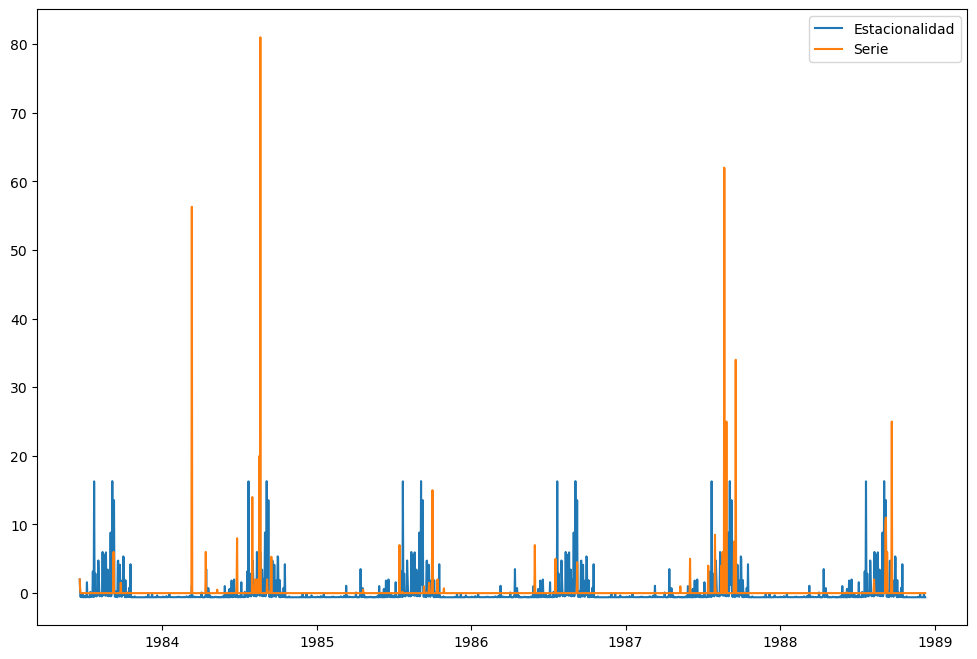

In [113]:
series = df_pixel['ba']
decomposition = seasonal_decompose(series, model='additive', period=365)  
seasonal = decomposition.seasonal
plt.figure(figsize=(12, 8)) 
plt.plot(seasonal[0:2000],label = 'Estacionalidad')
plt.plot(series[0:2000],label = 'Serie')
plt.legend()
plt.show()


In [186]:
threshold = seasonal.quantile(0.9)
fire_season_mask = (seasonal >= threshold).astype(int)

fsdf= fire_season_mask.reset_index()
fsdf['mes'] = fsdf['time'].dt.strftime('%m') 
fsdf['año'] = fsdf['time'].dt.year
fsdf = fsdf.pivot_table(index='mes', columns='año', values='seasonal', aggfunc='first')
fsdf = fsdf.fillna(0)
fsdf.T.sum()

mes
01     0.0
02     0.0
03     0.0
04     0.0
05     0.0
06     1.0
07     4.0
08     8.0
09    25.0
10     9.0
11     0.0
12     0.0
dtype: float64

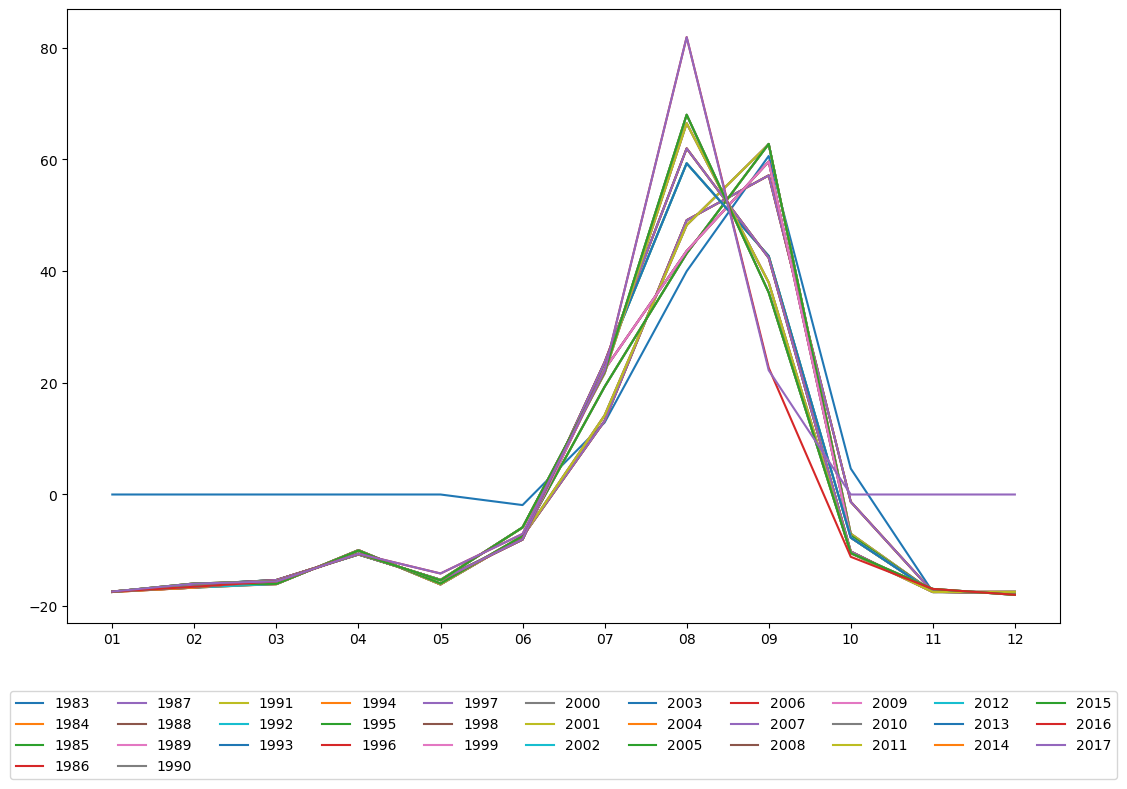

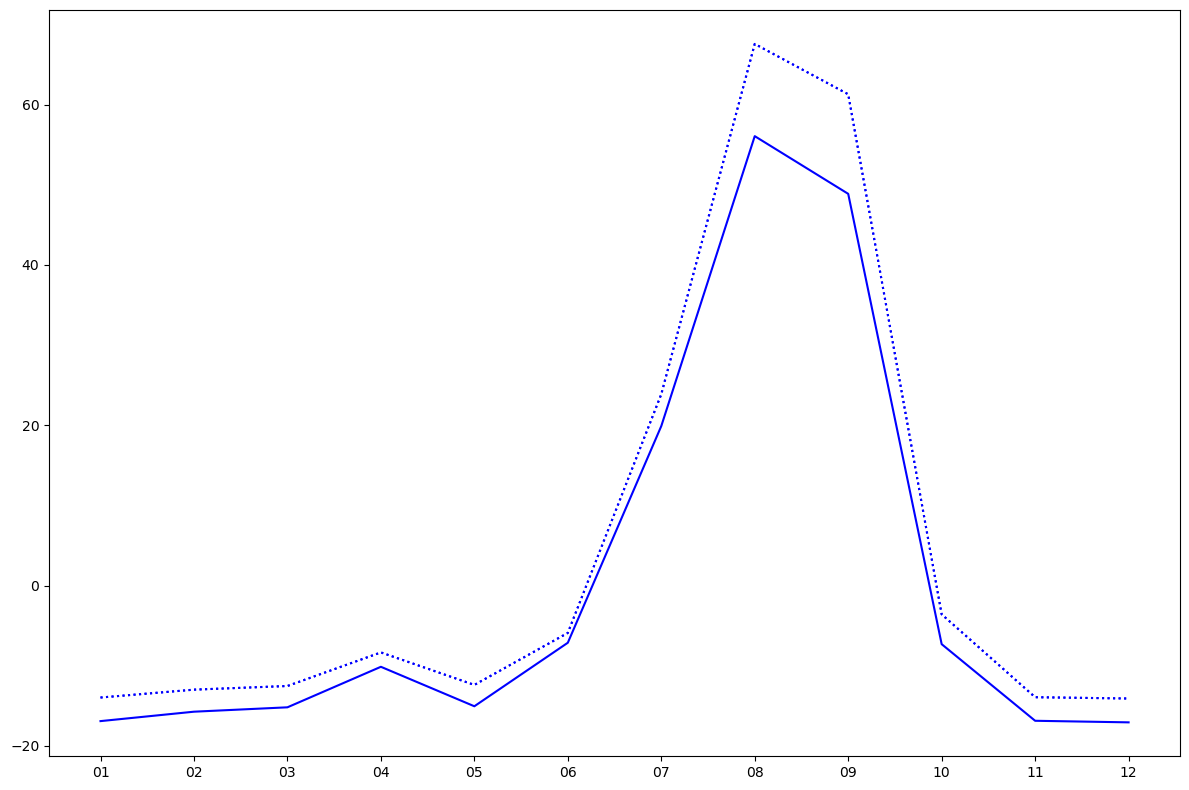

In [118]:
seasonal1 = seasonal.reset_index()
seasonal1['mes'] = seasonal1['time'].dt.strftime('%m') 
seasonal1['año'] = seasonal1['time'].dt.year
seasonal1 = seasonal1.pivot_table(index='mes', columns='año', values='seasonal', aggfunc='sum')
seasonal1 = seasonal1.fillna(0)

plt.figure(figsize=(12, 8)) 
for year in seasonal1.columns:
    serie_s = seasonal1[year]
    plt.plot(serie_s,label = year)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=11) 
plt.tight_layout()
plt.show()

serie_s = seasonal1.T.mean()
serie_s_std = seasonal1.T.std()
plt.figure(figsize=(12, 8)) 
plt.plot(serie_s, color='Blue')
plt.plot(serie_s + serie_s_std, linestyle='dotted', color='Blue')
plt.plot(serie_s + serie_s_std, linestyle='dotted', color='Blue')
plt.tight_layout()
plt.show()

In [117]:
plt.plot(seasonal1)
plt.show()

año       1983       1984       1985       1986       1987       1988  \
mes                                                                     
01    0.000000 -17.366869 -17.366948 -17.366948 -17.366948 -17.366948   
02    0.000000 -16.668249 -16.078617 -16.078617 -16.078617 -16.668254   
03    0.000000 -16.044249 -16.044249 -16.044249 -16.044249 -16.014233   
04    0.000000  -9.952319  -9.952319  -9.952319  -9.952319  -9.998761   
05    0.000000 -16.088241 -16.088241 -16.088241 -16.088241 -16.088241   
06   -1.891233  -7.538542  -7.538542  -7.538542  -7.538542  -7.502481   
07   12.886305  13.175093  13.175093  13.175093  13.175093  14.154184   
08   39.962365  49.097517  49.097517  49.097517  49.097517  48.222062   
09   60.600607  57.119690  57.119690  57.119690  57.119690  62.698469   
10    4.635923  -1.310246  -1.310246  -1.310246  -1.310246  -7.023081   
11  -17.432803 -17.426798 -17.426798 -17.426798 -17.426798 -17.427762   
12  -17.592113 -17.586341 -17.586341 -17.586341 -17.586341 -17.574531   

año       1989       1990       1991       1992  ...       2008       2009  \
mes                                              ...                         
01  -17.367004 -17.367004 -17.367004 -17.367004  ... -17.395158 -17.395212   
02  -16.078622 -16.078622 -16.078622 -16.668259  ... -16.521216 -15.931582   
03  -16.014233 -16.014233 -16.014233 -15.998922  ... -15.537589 -15.537589   
04   -9.998761  -9.998761  -9.998761 -10.030496  ... -10.631900 -10.631900   
05  -16.088241 -16.088241 -16.088241 -15.933695  ... -15.302786 -15.302786   
06   -7.502481  -7.502481  -7.502481  -7.428239  ...  -5.914906  -5.914906   
07   14.154184  14.154184  14.154184  19.286305  ...  21.696608  21.696608   
08   48.222062  48.222062  48.222062  43.149335  ...  66.454213  66.454213   
09   62.698469  62.698469  62.698469  62.757552  ...  37.939914  37.939914   
10   -7.023081  -7.023081  -7.023081  -7.365613  ... -10.492729 -10.492729   
11  -17.427762 -17.427762 -17.427762 -17.427818  ... -17.455296 -17.455296   
12  -17.574531 -17.574531 -17.574531 -17.487722  ... -17.428735 -17.428735   

año       2010       2011       2012       2013       2014       2015  \
mes                                                                     
01  -17.395212 -17.395212 -17.395212 -17.395265 -17.395265 -17.395265   
02  -15.931582 -15.931582 -16.512396 -15.922762 -15.922762 -15.922762   
03  -15.537589 -15.537589 -15.562846 -15.562846 -15.562846 -15.562846   
04  -10.631900 -10.631900 -10.576740 -10.576740 -10.576740 -10.576740   
05  -15.302786 -15.302786 -15.357029 -15.357029 -15.357029 -15.357029   
06   -5.914906  -5.914906  -5.884906  -5.884906  -5.884906  -5.884906   
07   21.696608  21.696608  21.926911  21.926911  21.926911  21.926911   
08   66.454213  66.454213  67.978318  67.978318  67.978318  67.978318   
09   37.939914  37.939914  36.158831  36.158831  36.158831  36.158831   
10  -10.492729 -10.492729 -10.492328 -10.492328 -10.492328 -10.492328   
11  -17.455296 -17.455296 -16.904345 -16.904345 -16.904345 -16.904345   
12  -17.428735 -17.428735 -17.967839 -17.967839 -17.967839 -17.967839   

año       2016       2017  
mes                        
01  -17.395265 -17.368847  
02  -16.512399 -15.949236  
03  -15.552007 -15.552007  
04  -10.604005 -10.604005  
05  -14.141877 -14.141877  
06   -7.054603  -7.054603  
07   22.136305  22.136305  
08   81.872120  81.872120  
09   22.680171  22.234162  
10  -11.157685   0.000000  
11  -16.904304   0.000000  
12  -17.956033   0.000000  

[12 rows x 35 columns]

##### Hacemos las medias para cada día de todos los años para calcular la estación de incendios